In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # used because the normal cv2.imshow crashes colab
import struct
from pickle import TRUE




In [ ]:

def detect_objects():
    # Load image from file
    img = cv2.imread("0000000000.png")

    # Load class names from file
    yolo_base_path = "yolo/"
    yolo_classes_file = yolo_base_path + "coco.names"
    yolo_model_configuration = yolo_base_path + "yolov3.cfg"
    yolo_model_weights = yolo_base_path + "yolov3.weights"

    with open(yolo_classes_file, 'r') as f:
        classes = [line.strip() for line in f.readlines()]

    # Load neural network
    net = cv2.dnn.readNetFromDarknet(yolo_model_configuration, yolo_model_weights)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    # Generate 4D blob from input image
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (608, 608), swapRB=False, crop=False)

    # Get names of output layers
    layer_names = net.getLayerNames()
    output_layer_indices = net.getUnconnectedOutLayers()
    output_layer_names = [layer_names[i - 1] for i in output_layer_indices]

    # Invoke forward propagation through network
    net.setInput(blob)
    net_output = net.forward(output_layer_names)

    # Scan through all bounding boxes and keep only the ones with high confidence
    conf_threshold = 0.30
    class_ids = []
    confidences = []
    boxes = []

    for output in net_output:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                box = detection[0:4] * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
                (center_x, center_y, width, height) = box.astype("int")

                x = int(center_x - (width / 2))
                y = int(center_y - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Perform non-maxima suppression
    nms_threshold = 0.3
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    bboxes = []

    for i in indices.flatten():
        x, y, w, h = boxes[i]
        bboxes.append((x, y, w, h, class_ids[i], confidences[i]))

    # Show results
    for (x, y, w, h, class_id, confidence) in bboxes:
        color = (0, 255, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = f"{classes[class_id]}: {confidence:.2f}"
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return img,bboxes





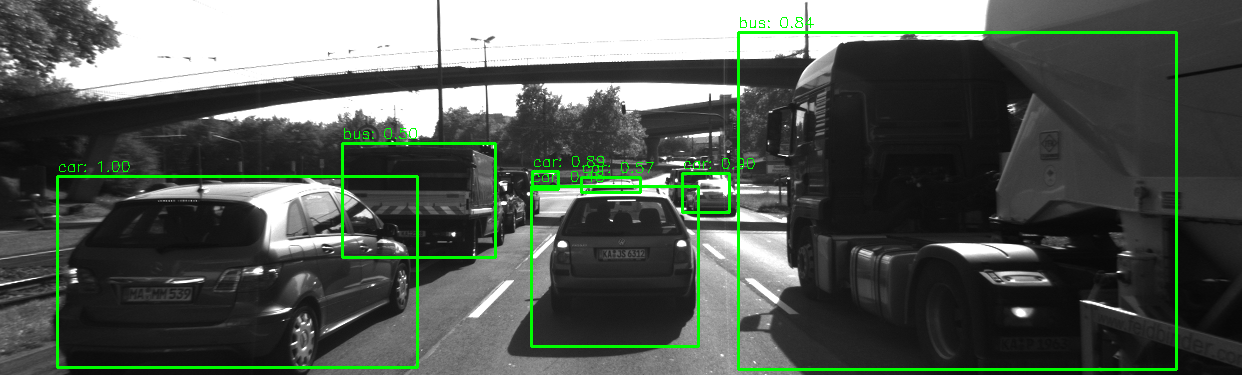

In [ ]:
img,bboxes = detect_objects()
boxed_img = img
# Show results
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# In this section we will try visualizing lidar points in topview for preparing on mounting lidar points by projection into camera photos in the next section.



*   We create the image and scale it
*   Change the color from red to green as distance increases from right to left



In [ ]:
class LidarPoint:
    def __init__(self, x, y, z, r):
        self.x = x
        self.y = y
        self.z = z
        self.r = r
class NormalPoint:
    def __init__(self, x, y):
        self.x = x
        self.y = y
class CompositePoint:
  def __init__(self, Normal, Lidar):
        self.Normal = Normal
        self.Lidar = Lidar



def read_pod(in_file):
    data = in_file.read(struct.calcsize('dddd'))
    if data:
        return struct.unpack('dddd', data)
    else:
        return None

def read_pod_vector(in_file):
    size = struct.unpack('l', in_file.read(struct.calcsize('l')))[0]
    vect = []
    for _ in range(size):
        t = read_pod(in_file)
        if t:
            vect.append(LidarPoint(*t))
    return vect
def read_lidar_pts(file_name):
    with open(file_name, 'rb') as in_file:
        return read_pod_vector(in_file)

In [ ]:
def show_lidar_topview_nofilter(lidar_points):
    world_size = (10.0, 20.0)  # width and height of sensor field in m
    image_size = (1000, 2000)  # corresponding top view image in pixels

    # create topview image
    topview_img = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)

    # plot LiDAR points into the image
    for point in lidar_points:
        xw = point.x  # world position in m with x facing forward from sensor
        yw = point.y  # world position in m with y facing left from sensor

        y = int((-xw * image_size[1] / world_size[1]) + image_size[1])
        x = int((-yw * image_size[0] / world_size[0]) + image_size[0] / 2)

        road_surface_lvl = -1.5  # define the heights for representing road surface points in z-axis
        # Remove all LiDAR points on the road surface while preserving measurements on the obstacles in the scene
        if (True):
            # Change the color of the LiDAR points such that x=0.0m corresponds to red while x=20.0m is shown as green
            red = min(255, int(255 * abs((xw - world_size[1]) / world_size[1])))
            green = min(255, int(255 * (1 - abs((xw - world_size[1]) / world_size[1]))))
            cv2.circle(topview_img, (x, y), 5, (0, green, red), -1)

    topview_img = cv2.rotate(topview_img, cv2.ROTATE_90_CLOCKWISE)
    return topview_img



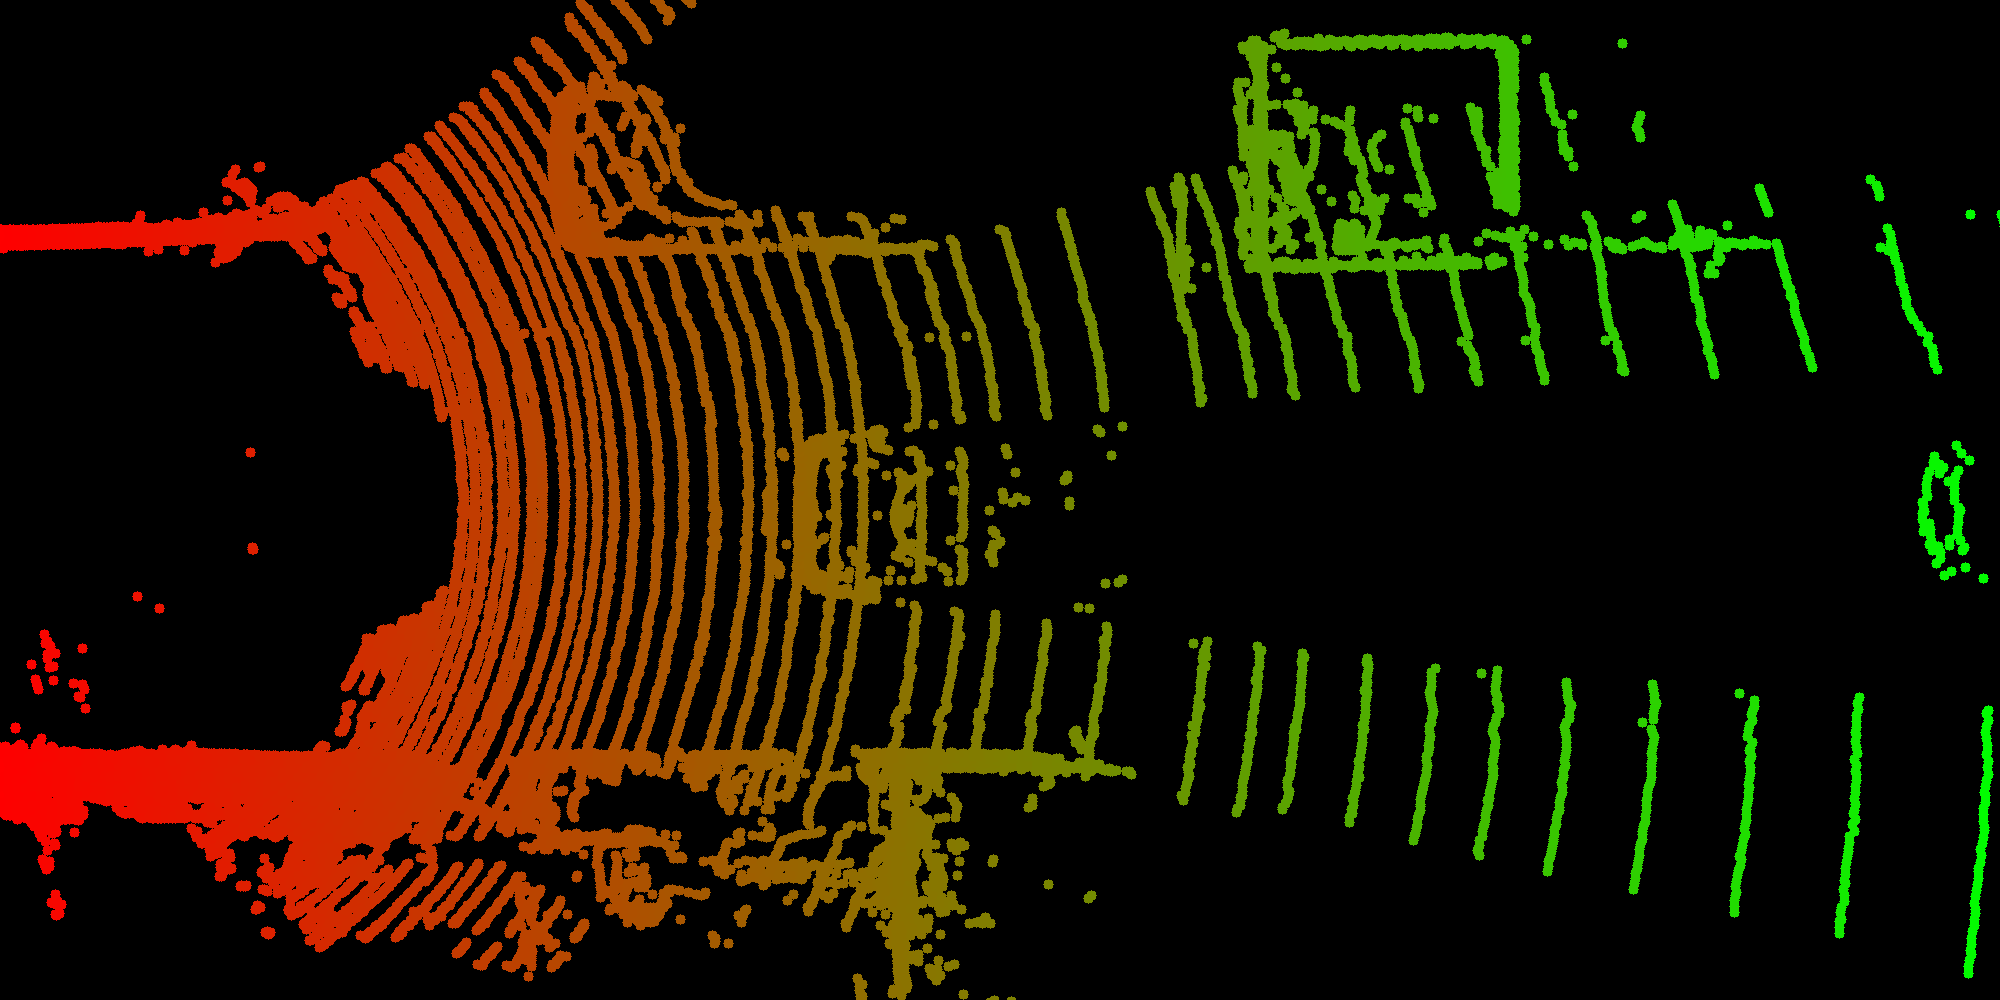

In [ ]:
 # display image
#window_name = "Top-View Perspective of LiDAR data"
lidar_points = read_lidar_pts("lidarcamera.dat")
topview_img = show_lidar_topview_nofilter(lidar_points)
cv2_imshow(topview_img)
cv2.waitKey(0)  # wait for key to be pressed
cv2.destroyAllWindows()

In [ ]:
def show_lidar_topview(lidar_points):
    world_size = (10.0, 20.0)  # width and height of sensor field in m
    image_size = (1000, 2000)  # corresponding top view image in pixels

    # create topview image
    topview_img = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
    total_points = 0
    selected_points = 0
    # plot LiDAR points into the image
    non_road_points = []
    for point in lidar_points:
        total_points= total_points+1
        xw = point.x  # world position in m with x facing forward from sensor
        yw = point.y  # world position in m with y facing left from sensor

        y = int((-xw * image_size[1] / world_size[1]) + image_size[1])
        x = int((-yw * image_size[0] / world_size[0]) + image_size[0] / 2)


        road_surface_lvl = -1.5  # define the heights for representing road surface points in z-axis
        # Remove all LiDAR points on the road surface while preserving measurements on the obstacles in the scene
        if point.z > road_surface_lvl:
            # Change the color of the LiDAR points such that x=0.0m corresponds to red while x=20.0m is shown as green
            red = min(255, int(255 * abs((xw - world_size[1]) / world_size[1])))
            green = min(255, int(255 * (1 - abs((xw - world_size[1]) / world_size[1]))))
            cv2.circle(topview_img, (x, y), 5, (0, green, red), -1)
            selected_points = selected_points+1
            non_road_points.append(point)

    # plot distance markers
    line_spacing = 2.0  # gap between distance markers
    n_markers = int(np.floor(world_size[1] / line_spacing))
    for i in range(n_markers):
        y = int((-(i * line_spacing) * image_size[0] / world_size[1]) + image_size[0])
        cv2.line(topview_img, (0, y), (image_size[1], y), (255, 0, 0))
    topview_img = cv2.rotate(topview_img, cv2.ROTATE_90_CLOCKWISE)
    print("Total points are ",total_points)
    print("Select points are ",selected_points)

    return topview_img,non_road_points



Total points are  114278
Select points are  78859


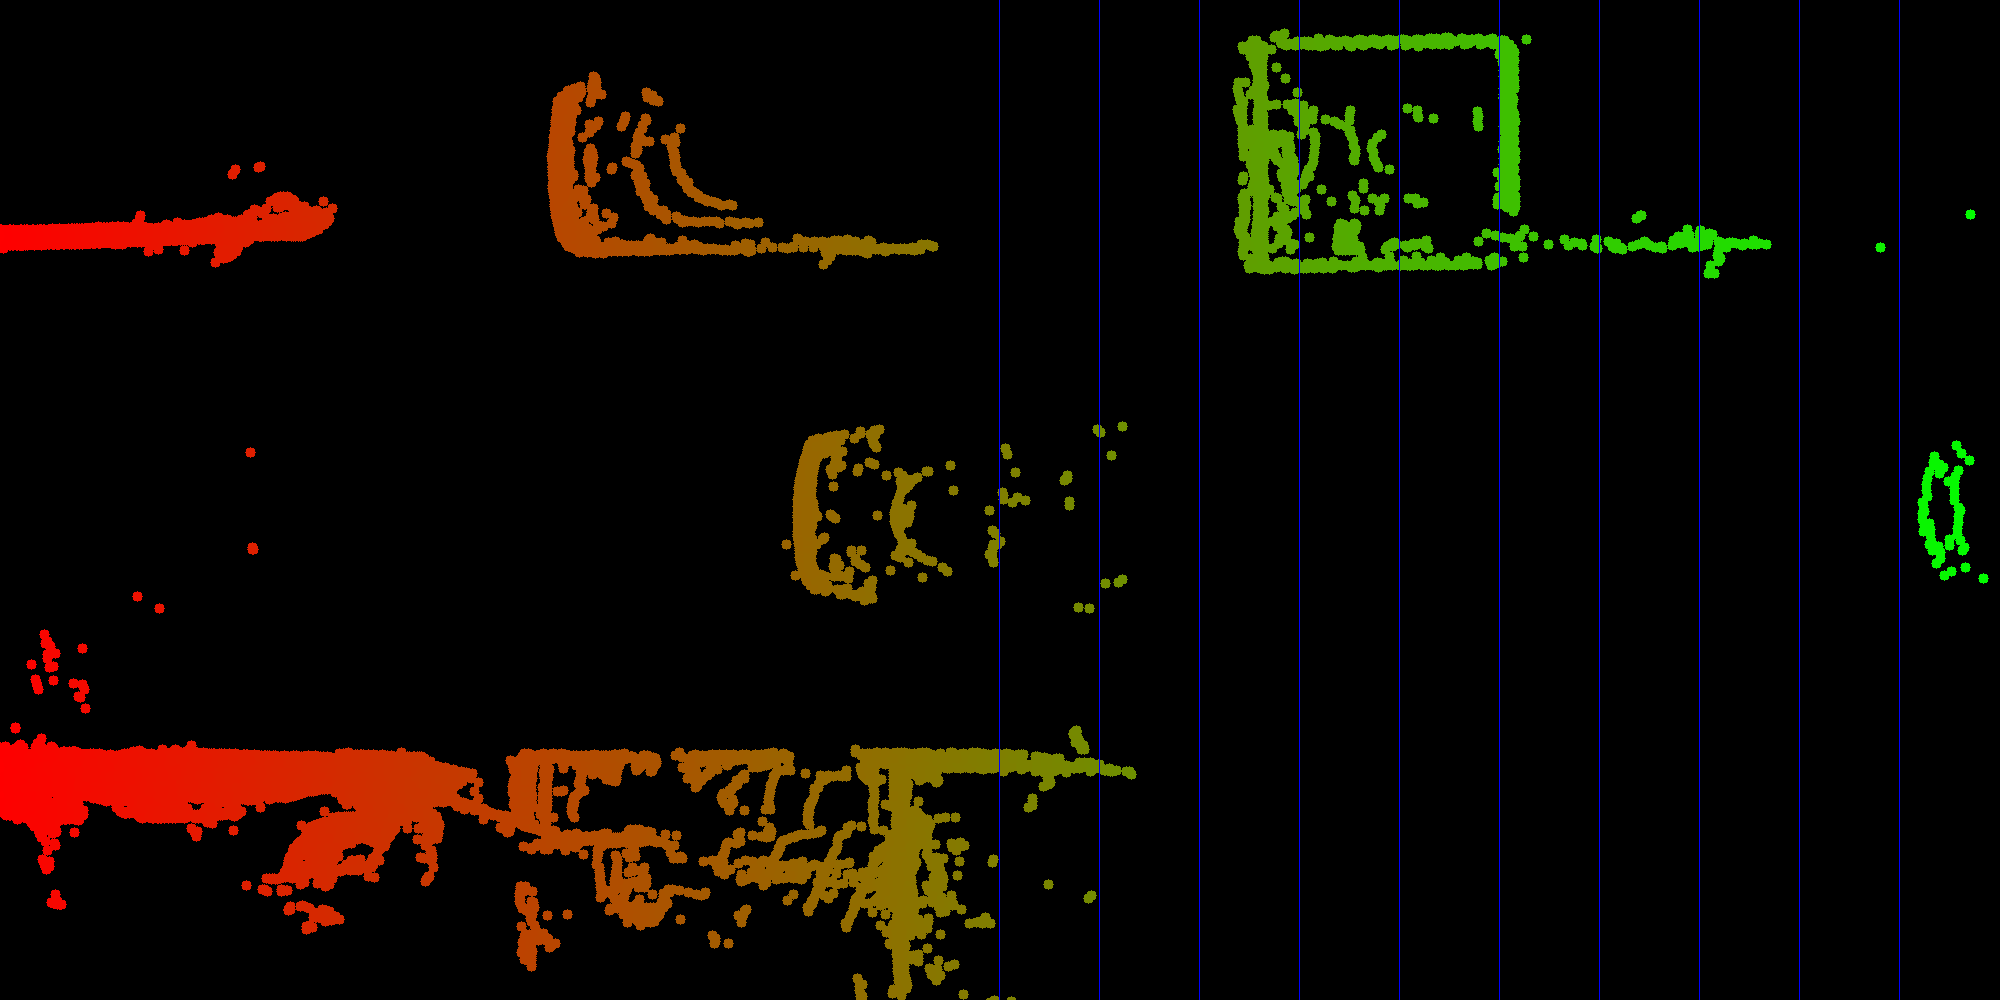

In [ ]:
 # display image
#window_name = "Top-View Perspective of LiDAR data"
lidar_points = read_lidar_pts("lidarcamera.dat")
topview_img,non_road_points = show_lidar_topview(lidar_points)
cv2_imshow(topview_img)
cv2.waitKey(0)  # wait for key to be pressed
cv2.destroyAllWindows()

# In this section we will mount the lidar points into camera image using calibration matrices including intrensic and extrensic parameters

in below table are the classification of each parameters:-

below are the equations :-












$\hat{P} = \begin{bmatrix} x \\ y \\ z \end{bmatrix} ⇒  \hat{P}’ = \begin{bmatrix} \frac { \alpha x}{z} + C_x \\ \frac{\beta y}{z} + C_y \end{bmatrix}  \ $




$ Euclidean ⇒ Homogenous $

$ (x,y)_{Image} ⇒  \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} , (x,y,z)_{Scene} ⇒  \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}  $



$ \vec P_h '  =  \begin{bmatrix} \alpha & 0 & C_x & 0 \\ 0 & \beta & C_y & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix} .  \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix} $
----
                Intresnic Calibration matrix

$ Homogenous ⇒ Euclidean $

$  \begin{bmatrix} x \\ y \\ w \end{bmatrix} ⇒ (\frac {  x}{w} , \frac {  y}{w})  ,  \begin{bmatrix} x \\ y \\ z \\ w \end{bmatrix} ⇒ (\frac {  x}{w} , \frac {  y}{w} ,\frac {  z}{w} )$

# 2D Translation

 ### $ \vec P' = \vec P + \vec t =  \begin{bmatrix} x + t_x \\ y + t_y \end{bmatrix} $

 ### $ \vec P_h'  =  \begin{bmatrix} x + t_x \\ y + t_y \\ 1 \end{bmatrix}  $

  ### $  = \begin{bmatrix} I & t \\ 0 & 1 \end{bmatrix} . \begin{bmatrix} x  \\ y  \\ 1 \end{bmatrix} = T.  \begin{bmatrix} x  \\ y  \\ 1 \end{bmatrix}  $



[link text](https://)**bold text**

In [ ]:
def load_calibration_data():
    RT = np.array([
        [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
        [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
        [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
        [0.0, 0.0, 0.0, 1.0]
    ])

    R_rect_00 = np.array([
        [9.999239e-01, 9.837760e-03, -7.445048e-03, 0.0],
        [-9.869795e-03, 9.999421e-01, -4.278459e-03, 0.0],
        [7.402527e-03, 4.351614e-03, 9.999631e-01, 0.0],
        [0, 0, 0, 1]
    ])

    P_rect_00 = np.array([
        [7.215377e+02, 0.0, 6.095593e+02, 0.0],
        [0.0, 7.215377e+02, 1.728540e+02, 0.0],
        [0.0, 0.0, 1.0, 0.0]
    ])

    return P_rect_00, R_rect_00, RT

def project_lidar_to_camera2(img, lidar_points):
    # Load calibration data
    P_rect_00, R_rect_00, RT = load_calibration_data()

    # Project LiDAR points
    vis_img = img.copy()
    overlay = vis_img.copy()  # overlay
    projected_points=[]

    number_lidar_points = 0
    number_projected_points = 0

    for point in lidar_points:
        number_lidar_points = number_lidar_points+1
        # Filter LiDAR points outside the consideration
        max_in_front = 20.0
        max_at_side = 5.0
        road_surface_lvl = -1.5
        min_reflectivity = 0.01
        if (point.x < 0.0) or (point.x > max_in_front) or (abs(point.y) > max_at_side) or (point.z < road_surface_lvl) or (point.r < min_reflectivity):
            continue

        # Convert current LiDAR point into homogeneous coordinates
        X = np.array([[point.x], [point.y], [point.z], [1.0]])

        # Apply the projection equation to map X onto the image plane of the camera
        Y = P_rect_00 @ R_rect_00 @ RT @ X
        number_projected_points = number_projected_points+1
        # Transform Y back into Euclidean coordinates
        pt = (int(Y[0] / Y[2]), int(Y[1] / Y[2]))
        projected_points.append(CompositePoint(pt, point))

        val = point.x
        max_val = 20.0
        red = min(255, int(255 * abs((val - max_val) / max_val)))
        green = min(255, int(255 * (1 - abs((val - max_val) / max_val))))
        cv2.circle(overlay, pt, 5, (0, green, red), -1)

    opacity = 0.6
    cv2.addWeighted(overlay, opacity, vis_img, 1 - opacity, 0, vis_img)
    print("The number of projected points is :",number_projected_points)
    print("The number of original points is :",number_lidar_points)
    return vis_img,projected_points




In [ ]:
def project_lidar_to_camera3(img, lidar_points):
    # Load calibration data
    P_rect_00, R_rect_00, RT = load_calibration_data()

    # Project LiDAR points
    vis_img = img.copy()
    overlay = vis_img.copy()  # overlay
    projected_points=[]

    number_lidar_points = 0
    number_projected_points = 0

    for point in lidar_points:

        # Filter LiDAR points outside the consideration
        max_in_front = 20.0
        max_at_side = 5.0
        road_surface_lvl = -200
        min_reflectivity = -1
        if (point.x < 0.0) or (point.x > max_in_front) or (abs(point.y) > max_at_side) or (point.z < road_surface_lvl) or (point.r < min_reflectivity):
            continue


        # Convert current LiDAR point into homogeneous coordinates
        X = np.array([[point.x], [point.y], [point.z], [1.0]])

        # Apply the projection equation to map X onto the image plane of the camera
        Y = P_rect_00 @ R_rect_00 @ RT @ X

        # Transform Y back into Euclidean coordinates
        pt = (int(Y[0] / Y[2]), int(Y[1] / Y[2]))
        projected_points.append(CompositePoint(pt, point))

        val = point.x
        max_val = 20.0
        red = min(255, int(255 * abs((val - max_val) / max_val)))
        green = min(255, int(255 * (1 - abs((val - max_val) / max_val))))
        cv2.circle(overlay, pt, 5, (0, green, red), -1)

    opacity = 0.6
    cv2.addWeighted(overlay, opacity, vis_img, 1 - opacity, 0, vis_img)

    return vis_img,projected_points


<ipython-input-36-0b95d92704a8>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt = (int(Y[0] / Y[2]), int(Y[1] / Y[2]))


The number of projected points is : 27898
The number of original points is : 114278
Number of final points is 78859


<ipython-input-38-7991819f968c>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt = (int(Y[0] / Y[2]), int(Y[1] / Y[2]))


The number of points without projection filtering is  38648


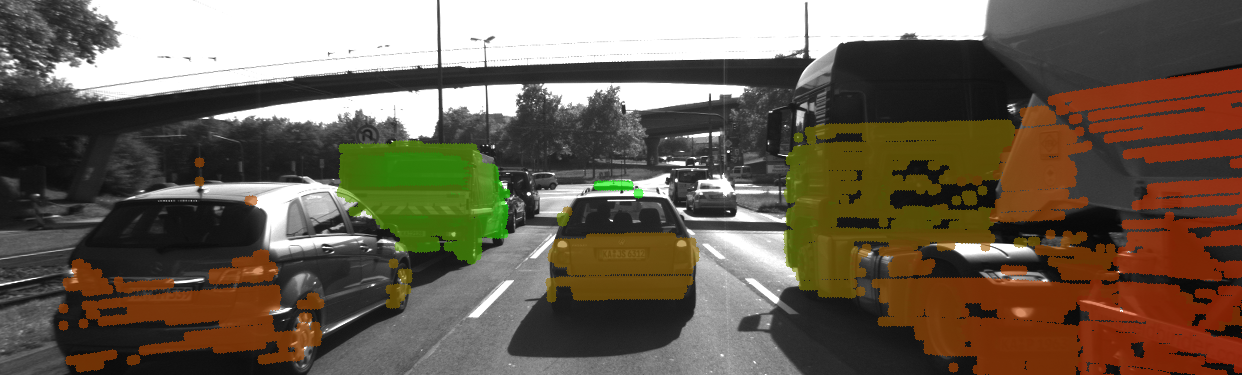

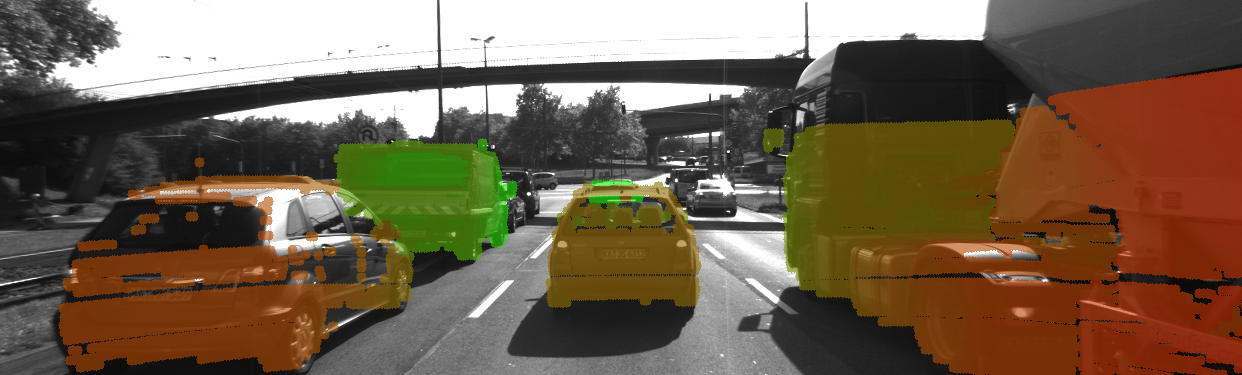

In [ ]:

img = cv2.imread("0000000000.png")
vis_img,projected_points = project_lidar_to_camera2(img,lidar_points)



print("Number of final points is",len(non_road_points))
image_without_projection_filterin_but_with_road_filtering,projected_points_without_projection_filtering = project_lidar_to_camera3(img,non_road_points)
print("The number of points without projection filtering is ",len(projected_points_without_projection_filtering))


cv2_imshow(vis_img)
cv2_imshow(image_without_projection_filterin_but_with_road_filtering)
cv2.waitKey(0)
cv2.destroyAllWindows()

# In this section we will filter lidar points that exceed bounding box boundaries or are within overlapping boxes


In [ ]:
# projected points now contains a mapping of point2d and point3d
projected_points[0].Lidar
projected_points[0].Normal






(-521, 29)

In [ ]:


def count_points_in_bboxes(points, bboxes):
    """
    Count how many bounding boxes each point lies in.

    :param points: List of points (tuples of x, y)
    :param bboxes: List of bounding boxes (dicts with 'x', 'y', 'width', 'height')
    :return: Dictionary with points as keys and counts as values
    """
    point_counts = {point: 0 for point in points}

    for point in points:
        for bbox in bboxes:
            bx, by, bw, bh , ss , bs = bbox
            px, py = point.Normal
            if(bx <= px <= bx + bw and by <= py <= by + bh):
                point_counts[point] += 1






    return point_counts




In [ ]:
def filter_points_with_single_bbox(point_counts):
    """
    Filter points that lie in exactly one bounding box.

    :param point_counts: Dictionary with points as keys and counts as values
    :return: List of points with a count of exactly 1
    """
    return [point for point, count in point_counts.items() if count == 1]

def not_filter_points_with_single_bbox(point_counts):
    """
    Filter points that lie in exactly one bounding box.

    :param point_counts: Dictionary with points as keys and counts as values
    :return: List of points with a count of exactly 1
    """
    return [point for point, count in point_counts.items() if count != 1]


<ipython-input-7-0b95d92704a8>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt = (int(Y[0] / Y[2]), int(Y[1] / Y[2]))


The number of projected points is : 5112
The number of original points is : 5112
The number of projected points is : 27898
The number of original points is : 114278


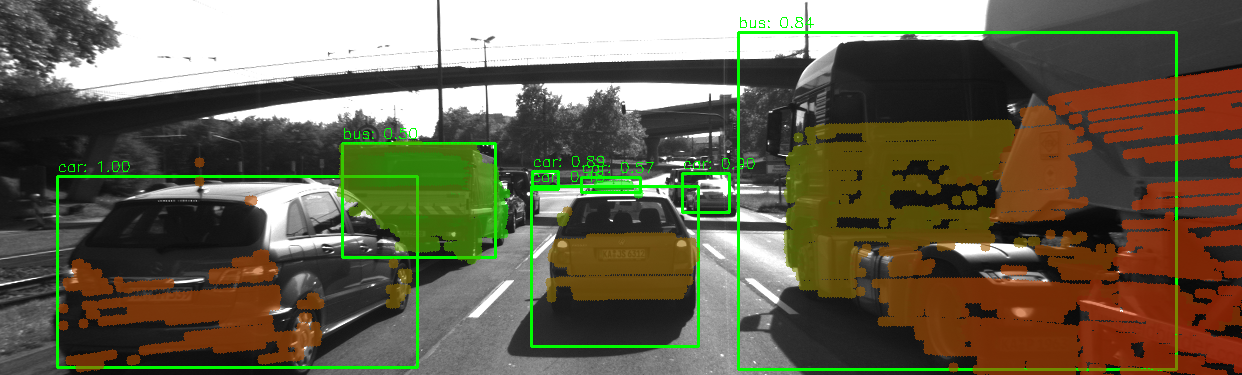

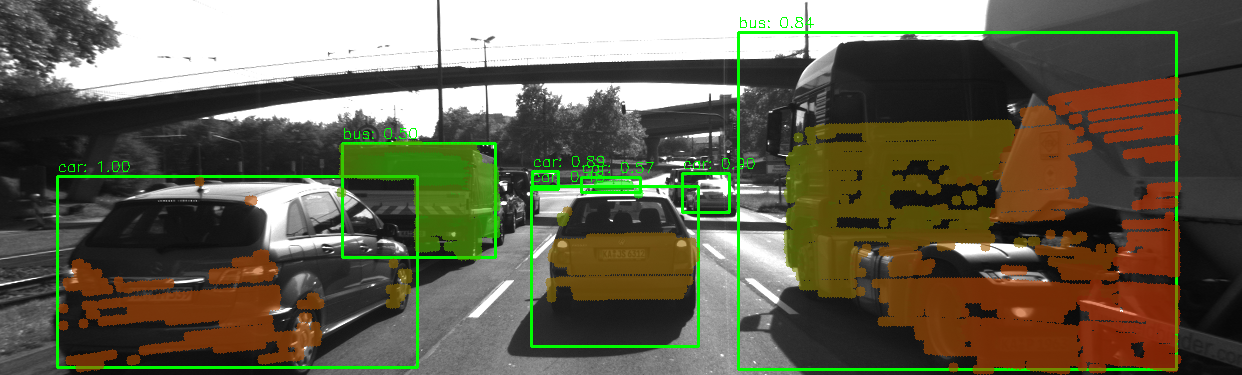

Total points are  5112
Select points are  5112
Total points are  5112
Select points are  5112


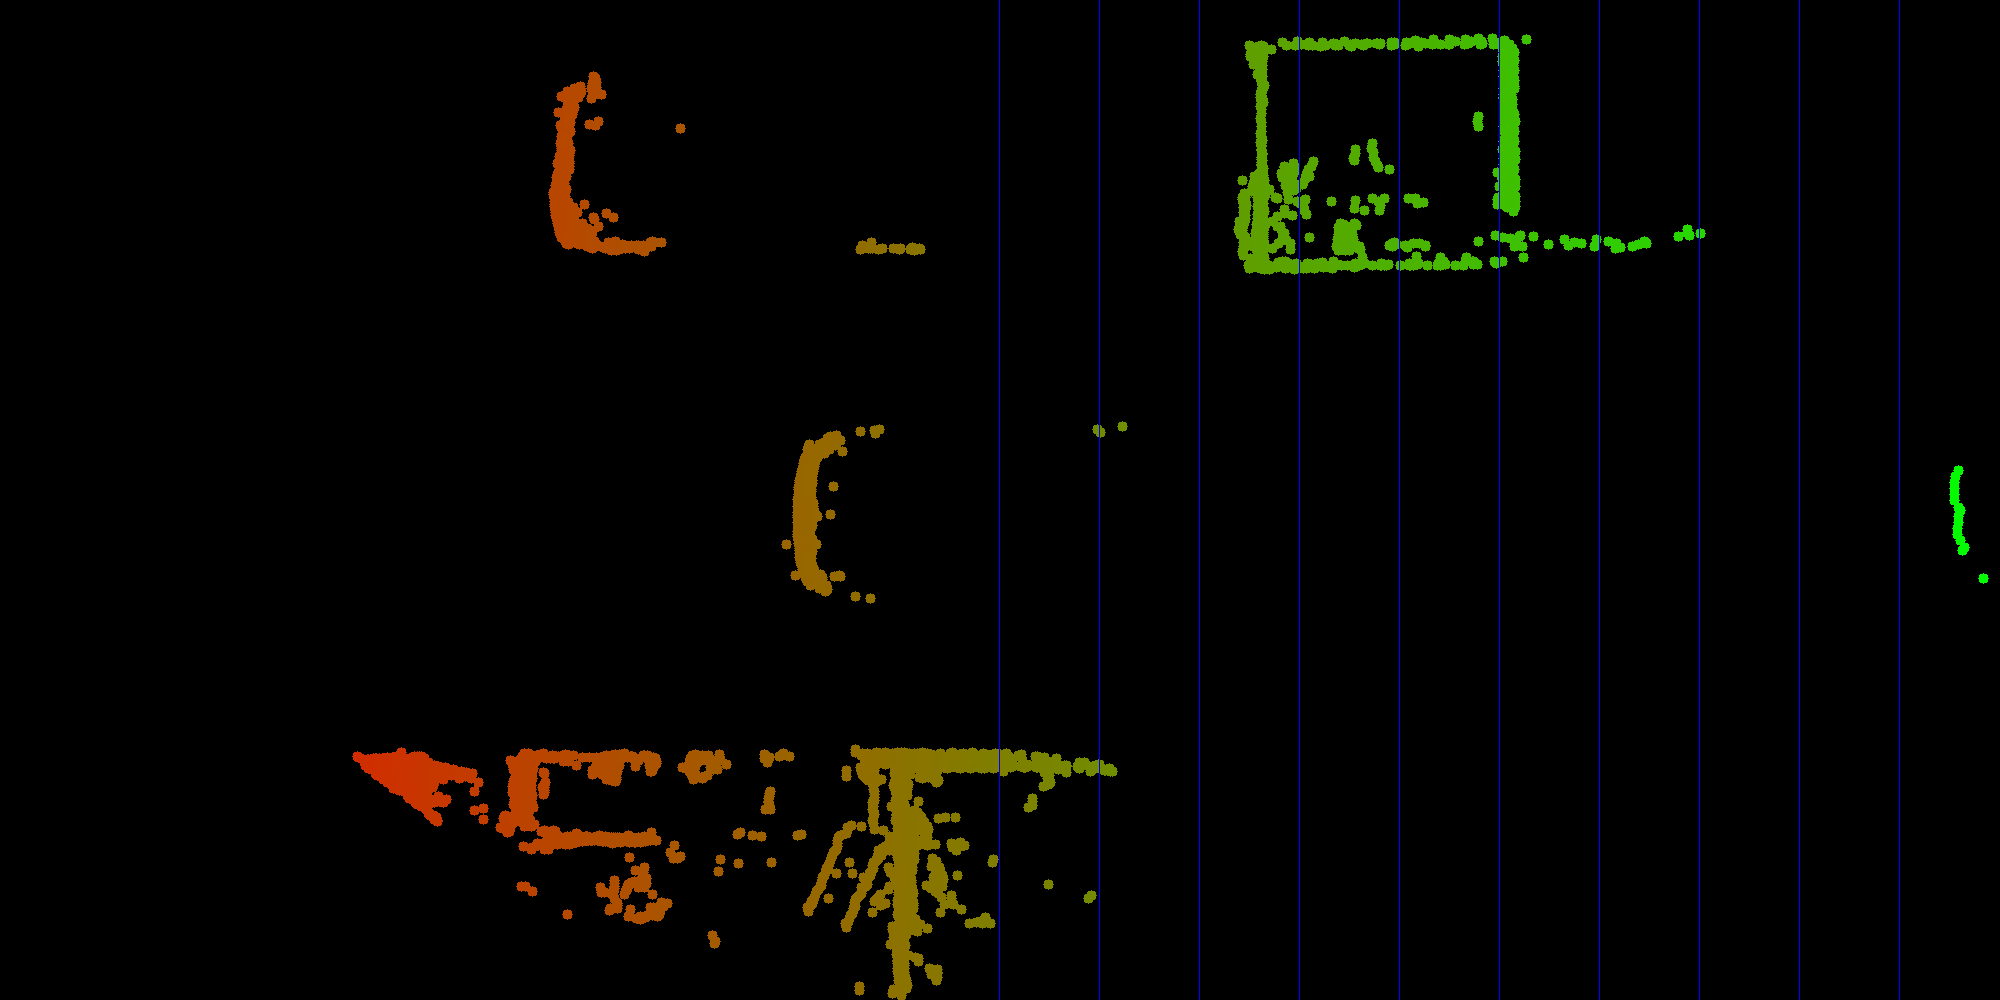

<ipython-input-8-935784a8d92c>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pt = (int(Y[0] / Y[2]), int(Y[1] / Y[2]))


Total points are  14277
Select points are  14277


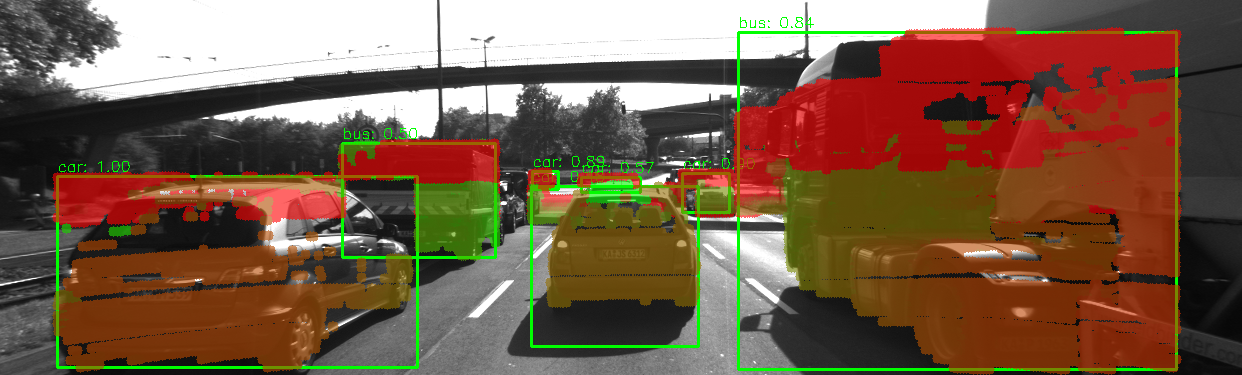

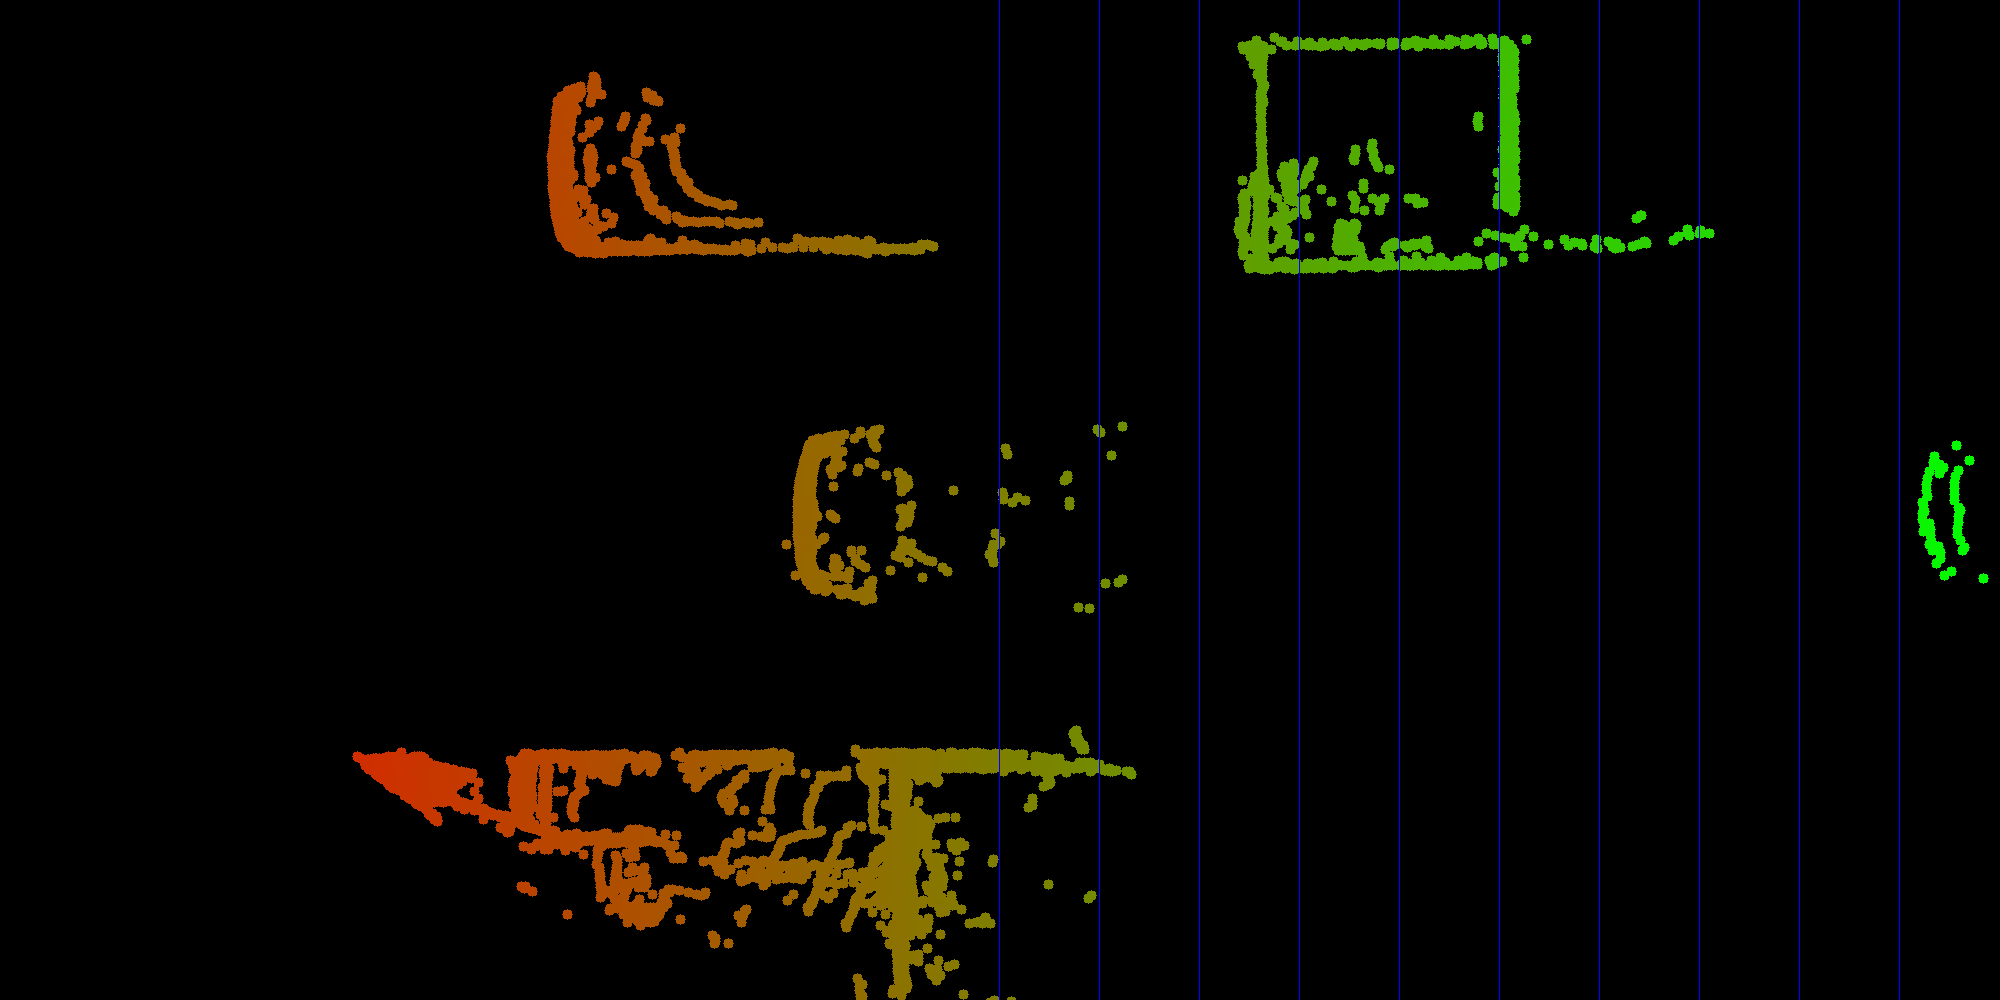

In [ ]:

#First Layer of filteration, filteration of overlapping

point_counts = {point: 0 for point in projected_points}

for point in projected_points:
    for bbox in bboxes:
        bx, by, bw, bh , ss , bs = bbox
        px, py = point.Normal
        if(bx <= px <= bx + bw and by <= py <= by + bh):
            point_counts[point] += 1








filtered_points = filter_points_with_single_bbox(point_counts)


lidar_param_only = []



for point in filtered_points:
  lidar_param_only.append(point.Lidar)


finalimg,finalset = project_lidar_to_camera2(boxed_img,lidar_param_only)
before_filter,finalset = project_lidar_to_camera2(boxed_img,lidar_points)







cv2_imshow(before_filter)
cv2_imshow(finalimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

show_lidar_topview(lidar_param_only)






clipped_lidar_img,not_important =show_lidar_topview(lidar_param_only)

cv2_imshow(clipped_lidar_img)
#cv2_imshow(show_lidar_topview(lidar_points))


point_counts = {point: 0 for point in projected_points_without_projection_filtering}

for point in projected_points_without_projection_filtering:
    for bbox in bboxes:
        bx, by, bw, bh , ss , bs = bbox
        px, py = point.Normal
        if(bx <= px <= bx + bw and by <= py <= by + bh):
            point_counts[point] += 1

accurate_filtered_points = filter_points_with_single_bbox(point_counts)
lidar_accurate_filtered_points = []



for point in accurate_filtered_points:
  lidar_accurate_filtered_points.append(point.Lidar)

accurate_final_img_2d,finalset = project_lidar_to_camera3(boxed_img,lidar_accurate_filtered_points)
accurate_final_img,not_important = show_lidar_topview(lidar_accurate_filtered_points)
cv2_imshow(accurate_final_img_2d)
cv2_imshow(accurate_final_img)










